# Multi-Class Classification Model to Predict Activity of Anti Cancer Peptides

### __Description of Dataset (obtained from the UCI ML Repository [1]:__

Membranolytic anticancer peptides (ACPs) are drawing increasing attention as potential future therapeutics against cancer, due to their ability to hinder the development of cellular resistance and their potential to overcome common hurdles of chemotherapy, e.g., side effects and cytotoxicity.

This dataset contains information on peptides (annotated for their one-letter amino acid code) and their anticancer activity on breast cancer cell lines (MCF7, MDA-MB-361, MT-1) and lung cancer cell lines (H-1299, A-549). EC50, IC50, LD50 and LC50 annotations on the reported breast and lung cancer cell lines were retained.

Two peptide datasets targeting breast and lung cancer cells were assembled and curated manually from CancerPPD. Peptides were split into __three classes for model training__: _**(1) very active**_ (EC/IC/LD/LC50 â€‰â‰¤â€‰ 5 Î¼M) - labeled as _**category '2'**_; _**(2) moderately active**_ (EC/IC/LD/LC50 values up to 50 Î¼M) - labeled as _**category '1'**_; and _**(3) inactive**_ (EC/IC/LD/LC50 â€‰>â€‰ 50 Î¼M) peptides - labeled as _**category '0'**_. Duplicates with conflicting class annotations were compared manually to the original sources, and, if necessary, corrected. The final training sets contained 949 peptides for Breast cancer and 901 peptides for Lung cancer. <_Note: For the purpose of this exercise, PepID# 133&134 in Breast cancer ACP dataset were removed manually due to possible string issue that caused KeyError while implementing biopython modules._>

Some approaches/assumptions employed in the original dataset curation:
1. Linear and l-chiral peptides were retained, while cyclic, mixed or d-chiral peptides were discarded. In the presence of both amidated and non-amidated data for the same sequence, only the value referred to the amidated peptide was retained.
2. If multiple class annotations were present for the same sequence, the most frequently represented class was chosen; in case of ties, the less active class was chosen. 
3. Since the CancerPPD is biased towards the annotation of active peptides, we built a set of presumably inactive peptides by randomly extracting 750 alpha-helical sequences from crystal structures deposited in the Protein Data Bank (7â€“30 amino acids). 

### __Objective:__
To build empirical __multiclass classification__ model given the ACP sequence and activity class labels.

### __Training Features:__
To generate more features for training, ACP sequences were fed to Bio.SeqUtils.ProtParam module in biopython library [2]. This open source library provided useful modules to obtain physical property  estimates for each ACP that are theoretically applicable for peptide applications, given their sequences:
1. gravy: KyteDolitle hydrophobicity index.
2. mw: molecular weight.
3. count_aa: counts of amino acids (aa).
4. isoelectric: estimate of isoelectric point.
5. aromaticity: fraction of aa with aromatic side chains.
6. helix: fraction of aa that tends to fold into helical structure.
7. sheet: fraction of aa that tends to form sheet structure.
8. hydrophobic: fraction of moderate to strong hydrophobic aa (A,V,L,I,F,W).
9. cationic: fraction of cationic aa (R,K).

## Import Required Libraries, Dataset and Pre-Process Datasets

In [1]:
!pip install Biopython -qq > /dev/null

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import Seq

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [3]:
# load csv datasets

path = 'https://raw.githubusercontent.com/nick-l33/ML-sklearn/main/Datasets/UCI%20ML%20Repo%20datasets/ACP/'
file1 = path + 'ACPBreast.csv' # '/content/ACPBreast.csv'  # ID 134, 133 were removed from breast dataset due to uncertain string issue (maybe special form of AA notation?).
df1 = pd.read_csv(file1)
file2 = path + 'ACPLung.csv'   # '/content/ACPLung.csv'
df2 = pd.read_csv(file2)

In [4]:
# Define useful built-in functions from Biopython's ProteinAnalysis class obj to perform basic protein analysis

def fun1(ProtAnal):
    ## fun1 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return Kyte Dolittle hydrophobicity index
    return ProtAnal.gravy()

def fun2(ProtAnal):
    ## fun2 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return MW
    return ProtAnal.molecular_weight()

def fun3(ProtAnal):
    ## fun3 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return dictionary of aa-freq pair
    return ProtAnal.count_amino_acids()

def fun4(ProtAnal):
    ## fun4 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return isoelectric_point
    return ProtAnal.isoelectric_point()

def fun5(ProtAnal):
    ## fun5 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return aromaticity
    return ProtAnal.aromaticity()

def fun6a(ProtAnal):
    ## fun6 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return secondary_structure_fraction: (helix, turn, sheet)
    return ProtAnal.secondary_structure_fraction()[0]

def fun6c(ProtAnal):
    ## fun6 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return secondary_structure_fraction: (helix, turn, sheet)
    return ProtAnal.secondary_structure_fraction()[2]

def fun7a(ProtAnal):
    ## fun7 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of AA('A')
    return ProtAnal.get_amino_acids_percent()['A']    

def fun7b(ProtAnal):
    ## fun7 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of AA('A')
    return ProtAnal.get_amino_acids_percent()['V']  

def fun7c(ProtAnal):
    ## fun7 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of AA('A')
    return ProtAnal.get_amino_acids_percent()['L']  

def fun7d(ProtAnal):
    ## fun7 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of AA('A')
    return ProtAnal.get_amino_acids_percent()['I']  

def fun7e(ProtAnal):
    ## fun7 takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of AVLIFW
    tot = (ProtAnal.get_amino_acids_percent()['F'] + ProtAnal.get_amino_acids_percent()['W'] +
           ProtAnal.get_amino_acids_percent()['L'] + ProtAnal.get_amino_acids_percent()['V'] +
           ProtAnal.get_amino_acids_percent()['A'] )
    return tot

def fun8a(ProtAnal):
    ## fun8a takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of AA('R')
    return ProtAnal.get_amino_acids_percent()['R']

def fun8b(ProtAnal):
    ## fun8b takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of AA('K')
    return ProtAnal.get_amino_acids_percent()['K']  

def fun8c(ProtAnal):
    ## fun8c takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of AA('H')
    return ProtAnal.get_amino_acids_percent()['H']  

def fun8d(ProtAnal):
    ## fun8d takes a ProtAnal object to return analysis of built-in function in biopython
    ## return fraction of RK
    tot = (ProtAnal.get_amino_acids_percent()['K'] + ProtAnal.get_amino_acids_percent()['R'] )
       #    + ProtAnal.get_amino_acids_percent()['H'])
    return tot

In [5]:
df1.tail(7)   # ID 134, 133 were removed from dataset due to string issue (maybe special form of AA).

,ID,sequence,class
940,943,YKKFRQLIQVN,inactive - virtual
941,944,YLADLFLAPQIHGAINRFQ,inactive - virtual
942,945,YLDKEVKLIKKMGNHLTNLRRVA,inactive - virtual
943,946,YLSESVETIKKLGDHITSLKKLW,inactive - virtual
944,947,YPIVDAAMRQLTETG,inactive - virtual
945,948,YQNIVKAVQYAARKLQ,inactive - virtual
946,949,YQQQKKYLGRMTE,inactive - virtual


In [6]:
df1.isna().sum()

ID          0
sequence    0
class       0
dtype: int64

In [7]:
df1.rename(columns={'class':'activity'}, inplace=True)
df2.rename(columns={'class':'activity'}, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        947 non-null    int64 
 1   sequence  947 non-null    object
 2   activity  947 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.3+ KB


In [8]:
df1.groupby('activity').size() # imbalanced class

activity
inactive - exp         83
inactive - virtual    750
mod. active            96
very active            18
dtype: int64

In [9]:
# combine all inactive peptides as grp 0 
df1.activity = df1.activity.map({'inactive - exp':0,'inactive - virtual':0,'mod. active':1,'very active':2})
df1.groupby('activity').size()

activity
0    833
1     96
2     18
dtype: int64

In [10]:
df2.activity = df2.activity.map({'inactive - exp':0,'inactive - virtual':0,'mod. active':1,'very active':2})
df2.groupby('activity').size()

activity
0    802
1     75
2     24
dtype: int64

In [11]:
df1['prot_anal'] = df1.sequence.apply(ProteinAnalysis) # return protein analysis obj for all peptide sequences
df1['gravy'] = df1.prot_anal.apply(fun1)
df1['mw'] = df1.prot_anal.apply(fun2)
df1['isoelectric'] = df1.prot_anal.apply(fun4)
df1['aromaticity'] = df1.prot_anal.apply(fun5)
df1['helix'] = df1.prot_anal.apply(fun6a)
df1['sheet'] = df1.prot_anal.apply(fun6c)
df1['hydrophobic'] = df1.prot_anal.apply(fun7e)
df1['cationic'] = df1.prot_anal.apply(fun8d)
df1['aa_count'] = df1.prot_anal.apply(fun3)

In [12]:
df2['prot_anal'] = df2.sequence.apply(ProteinAnalysis) # return protein analysis obj for all peptide sequences
df2['gravy'] = df2.prot_anal.apply(fun1)
df2['mw'] = df2.prot_anal.apply(fun2)
df2['isoelectric'] = df2.prot_anal.apply(fun4)
df2['aromaticity'] = df2.prot_anal.apply(fun5)
df2['helix'] = df2.prot_anal.apply(fun6a)
df2['sheet'] = df2.prot_anal.apply(fun6c)
df2['hydrophobic'] = df2.prot_anal.apply(fun7e)
df2['cationic'] = df2.prot_anal.apply(fun8d)
df2['aa_count'] = df2.prot_anal.apply(fun3)

In [13]:
a1 = pd.DataFrame(df1.aa_count.to_list())
a1['ID'] = df1.ID
df1 = df1.merge(a1, left_on='ID', right_on='ID').drop('aa_count', axis=1)
df1.set_index(['ID'], inplace=True)
df1.sample(7)

,sequence,activity,prot_anal,gravy,mw,isoelectric,aromaticity,helix,sheet,hydrophobic,...,M,N,P,Q,R,S,T,V,W,Y
ID,,,,,,,,,,,,,,,,,,,,,
475,IDDLRVIARENLERRRK,0,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,-1.252941,2152.4608,10.612673,0.000000,0.294118,0.294118,0.235294,...,0,1,0,0,5,0,0,1,0,0
50,FAKLLAKLAKKIL,0,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,0.946154,1456.9000,10.477740,0.076923,0.461538,0.538462,0.615385,...,0,0,0,0,0,0,0,0,0,0
279,DLKQAESWLHKQAQKEGWSKAARLH,0,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,-1.308000,2946.2819,9.526638,0.080000,0.200000,0.360000,0.360000,...,0,0,0,3,1,2,0,0,2,0
883,TPEEYQTYVAQVDK,0,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,-1.200000,1670.7707,4.136537,0.142857,0.285714,0.214286,0.214286,...,0,0,1,2,0,0,2,2,0,2
6,ETFSDWWKLLAE,1,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,-0.458333,1524.6709,4.426700,0.250000,0.416667,0.416667,0.500000,...,0,0,0,0,0,1,1,0,2,0
788,SLLPTLSAIAEL,0,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,1.325000,1227.4468,4.050028,0.000000,0.416667,0.583333,0.500000,...,0,0,1,0,0,2,1,0,0,0
813,SRDLQEKYERHMEKLIELANKEVERT,0,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,-1.496154,3245.6215,5.663687,0.038462,0.230769,0.423077,0.192308,...,1,1,0,1,3,1,1,1,0,1


In [14]:
a2 = pd.DataFrame(df2.aa_count.to_list())
a2['ID'] = df2.ID
df2 = df2.merge(a2, left_on='ID', right_on='ID').drop('aa_count', axis=1)
df2.set_index(['ID'], inplace=True) 
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 1 to 901
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sequence     901 non-null    object 
 1   activity     901 non-null    int64  
 2   prot_anal    901 non-null    object 
 3   gravy        901 non-null    float64
 4   mw           901 non-null    float64
 5   isoelectric  901 non-null    float64
 6   aromaticity  901 non-null    float64
 7   helix        901 non-null    float64
 8   sheet        901 non-null    float64
 9   hydrophobic  901 non-null    float64
 10  cationic     901 non-null    float64
 11  A            901 non-null    int64  
 12  C            901 non-null    int64  
 13  D            901 non-null    int64  
 14  E            901 non-null    int64  
 15  F            901 non-null    int64  
 16  G            901 non-null    int64  
 17  H            901 non-null    int64  
 18  I            901 non-null    int64  
 19  K       

## EDA and Display Correlation Matrix for Predictors

In [15]:
df1_2 = df1[(df1.activity==2)][['hydrophobic','cationic','aromaticity','helix','sheet','isoelectric','gravy']]

df1_2.sort_values(['hydrophobic','cationic','aromaticity','helix','sheet','isoelectric','gravy'], ascending=False).T

ID,91,86,28,27,69,140,144,100,179,196,156,198,92,162,128,127,88,93
hydrophobic,0.692308,0.692308,0.684211,0.647059,0.608696,0.50000,0.500000,0.500000,0.476190,0.466667,0.444444,0.428571,0.411765,0.384615,0.370370,0.357143,0.352941,0.346154
cationic,0.307692,0.153846,0.315789,0.352941,0.391304,0.50000,0.388889,0.125000,0.333333,0.333333,0.388889,0.357143,0.294118,0.269231,0.481481,0.428571,0.294118,0.192308
aromaticity,0.153846,0.153846,0.052632,0.058824,0.043478,0.10000,0.222222,0.062500,0.047619,0.266667,0.222222,0.214286,0.117647,0.115385,0.370370,0.357143,0.117647,0.038462
helix,0.538462,0.538462,0.368421,0.352941,0.347826,0.35000,0.500000,0.500000,0.428571,0.533333,0.444444,0.500000,0.529412,0.346154,0.370370,0.357143,0.470588,0.384615
sheet,0.538462,0.538462,0.631579,0.588235,0.565217,0.40000,0.277778,0.250000,0.380952,0.200000,0.222222,0.214286,0.235294,0.230769,0.000000,0.000000,0.294118,0.230769
isoelectric,10.477740,10.002737,10.699318,10.699318,10.903296,10.95442,10.778421,10.002737,11.999968,10.602487,10.778421,10.602487,10.602487,10.778421,11.079295,10.489538,10.602487,11.999968
gravy,0.969231,1.476923,0.684211,0.435294,0.221739,-0.63500,-0.083333,1.612500,-0.095238,-0.060000,-0.338889,-0.264286,0.858824,-0.138462,-1.900000,-1.514286,0.747059,0.273077


In [16]:
df1_0 = df1[(df1.activity==0)][['hydrophobic','cationic','aromaticity','helix','sheet','isoelectric','gravy']]

df1_0.sort_values(['hydrophobic','cationic','aromaticity','helix','sheet','isoelectric','gravy'], ascending=False).head(20).T

ID,194,64,80,34,219,79,66,73,8,68,74,78,169,191,909,916,36,48,131,75
hydrophobic,1.000,0.857143,0.833333,0.800000,0.800000,0.750000,0.750000,0.750000,0.733333,0.727273,0.727273,0.727273,0.727273,0.727273,0.727273,0.727273,0.714286,0.714286,0.705882,0.700000
cationic,0.000,0.142857,0.166667,0.200000,0.100000,0.250000,0.250000,0.250000,0.266667,0.272727,0.272727,0.272727,0.272727,0.272727,0.000000,0.000000,0.285714,0.285714,0.294118,0.300000
aromaticity,0.200,0.142857,0.166667,0.200000,0.100000,0.083333,0.083333,0.083333,0.066667,0.090909,0.090909,0.090909,0.090909,0.000000,0.090909,0.000000,0.214286,0.142857,0.000000,0.100000
helix,0.600,0.428571,0.666667,0.400000,0.400000,0.500000,0.416667,0.416667,0.400000,0.454545,0.454545,0.454545,0.454545,0.454545,0.454545,0.636364,0.428571,0.428571,0.352941,0.500000
sheet,0.800,0.714286,0.666667,0.600000,0.600000,0.666667,0.666667,0.666667,0.666667,0.636364,0.636364,0.636364,0.636364,0.636364,0.545455,0.454545,0.500000,0.571429,0.705882,0.600000
isoelectric,5.525,8.750052,8.750052,8.750052,8.795051,10.302064,10.302064,10.302064,10.477740,10.302064,10.302064,10.302064,10.302064,10.301935,5.184989,5.494989,10.477740,10.477740,10.602487,10.302064
gravy,2.060,1.700000,2.016667,1.260000,1.630000,1.291667,1.125000,1.125000,1.013333,1.063636,1.063636,1.063636,1.063636,1.190909,1.990909,2.018182,0.814286,0.885714,0.829412,0.990000


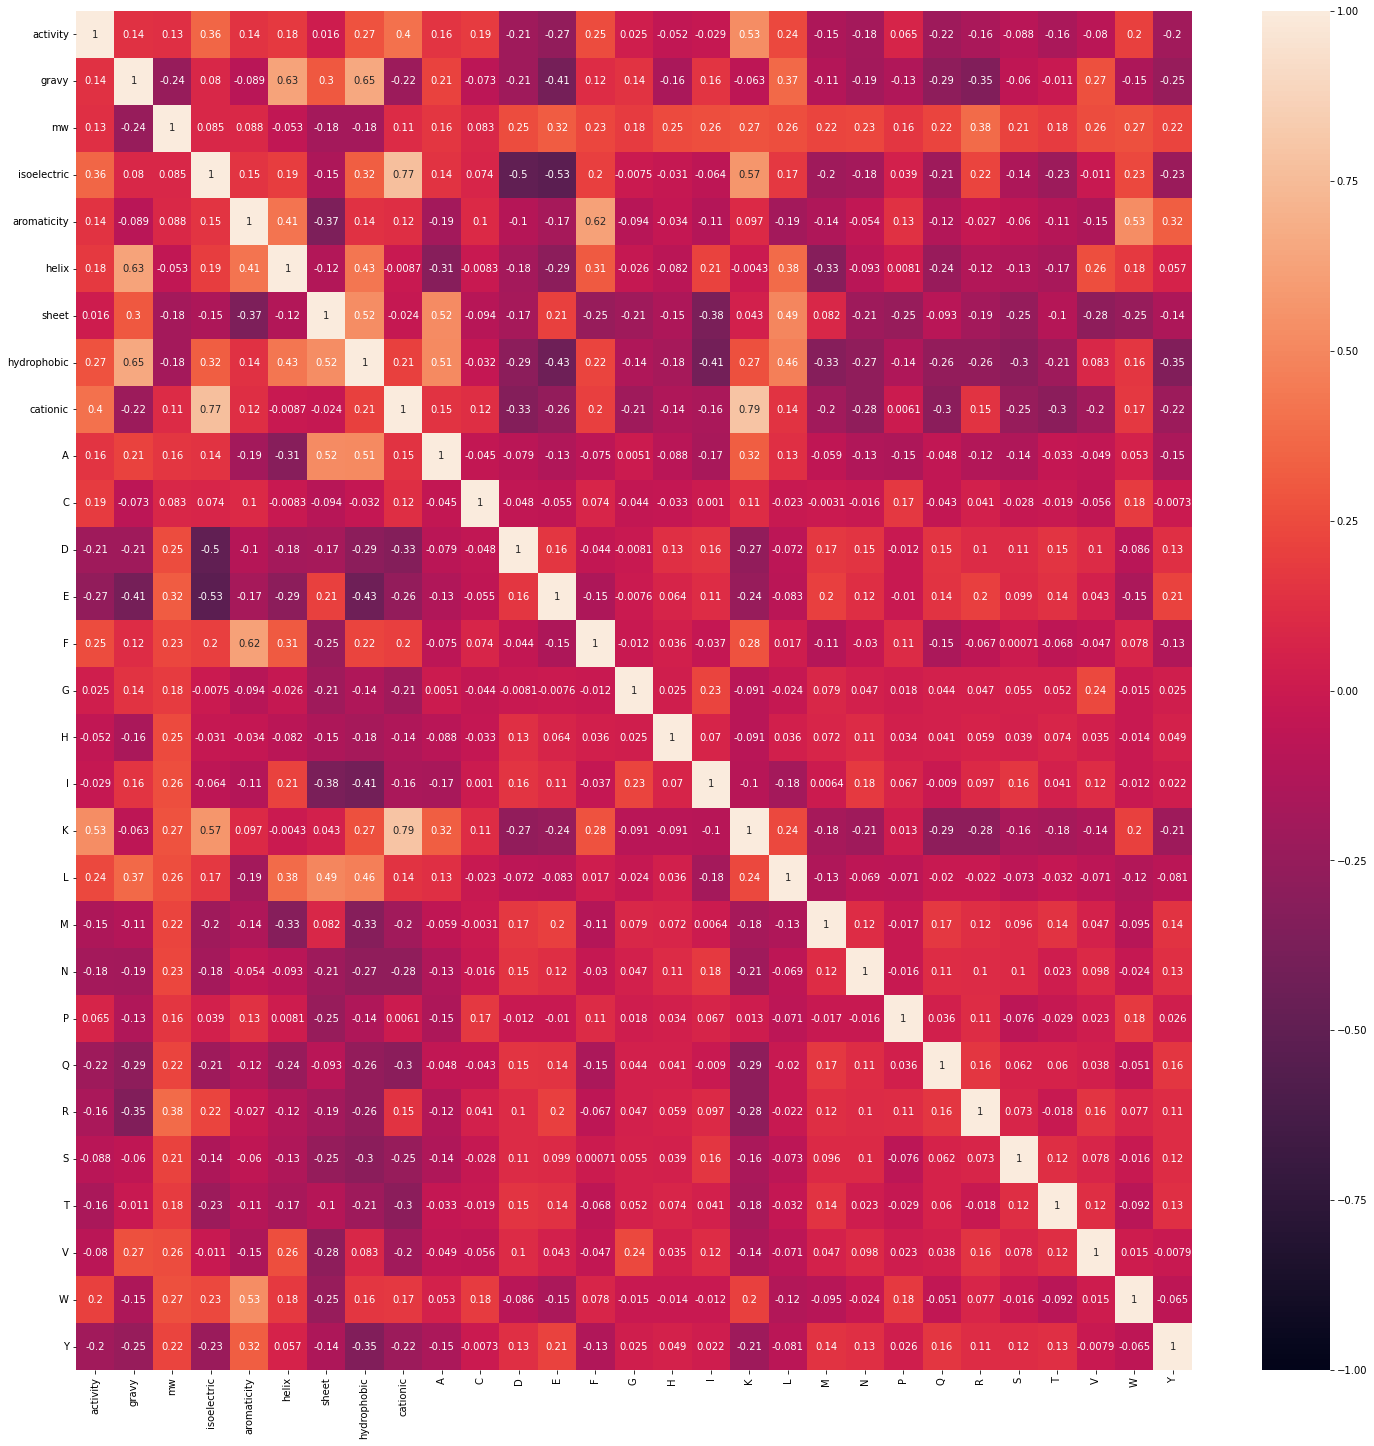

In [17]:
corr_mat1 = df1.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr_mat1, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

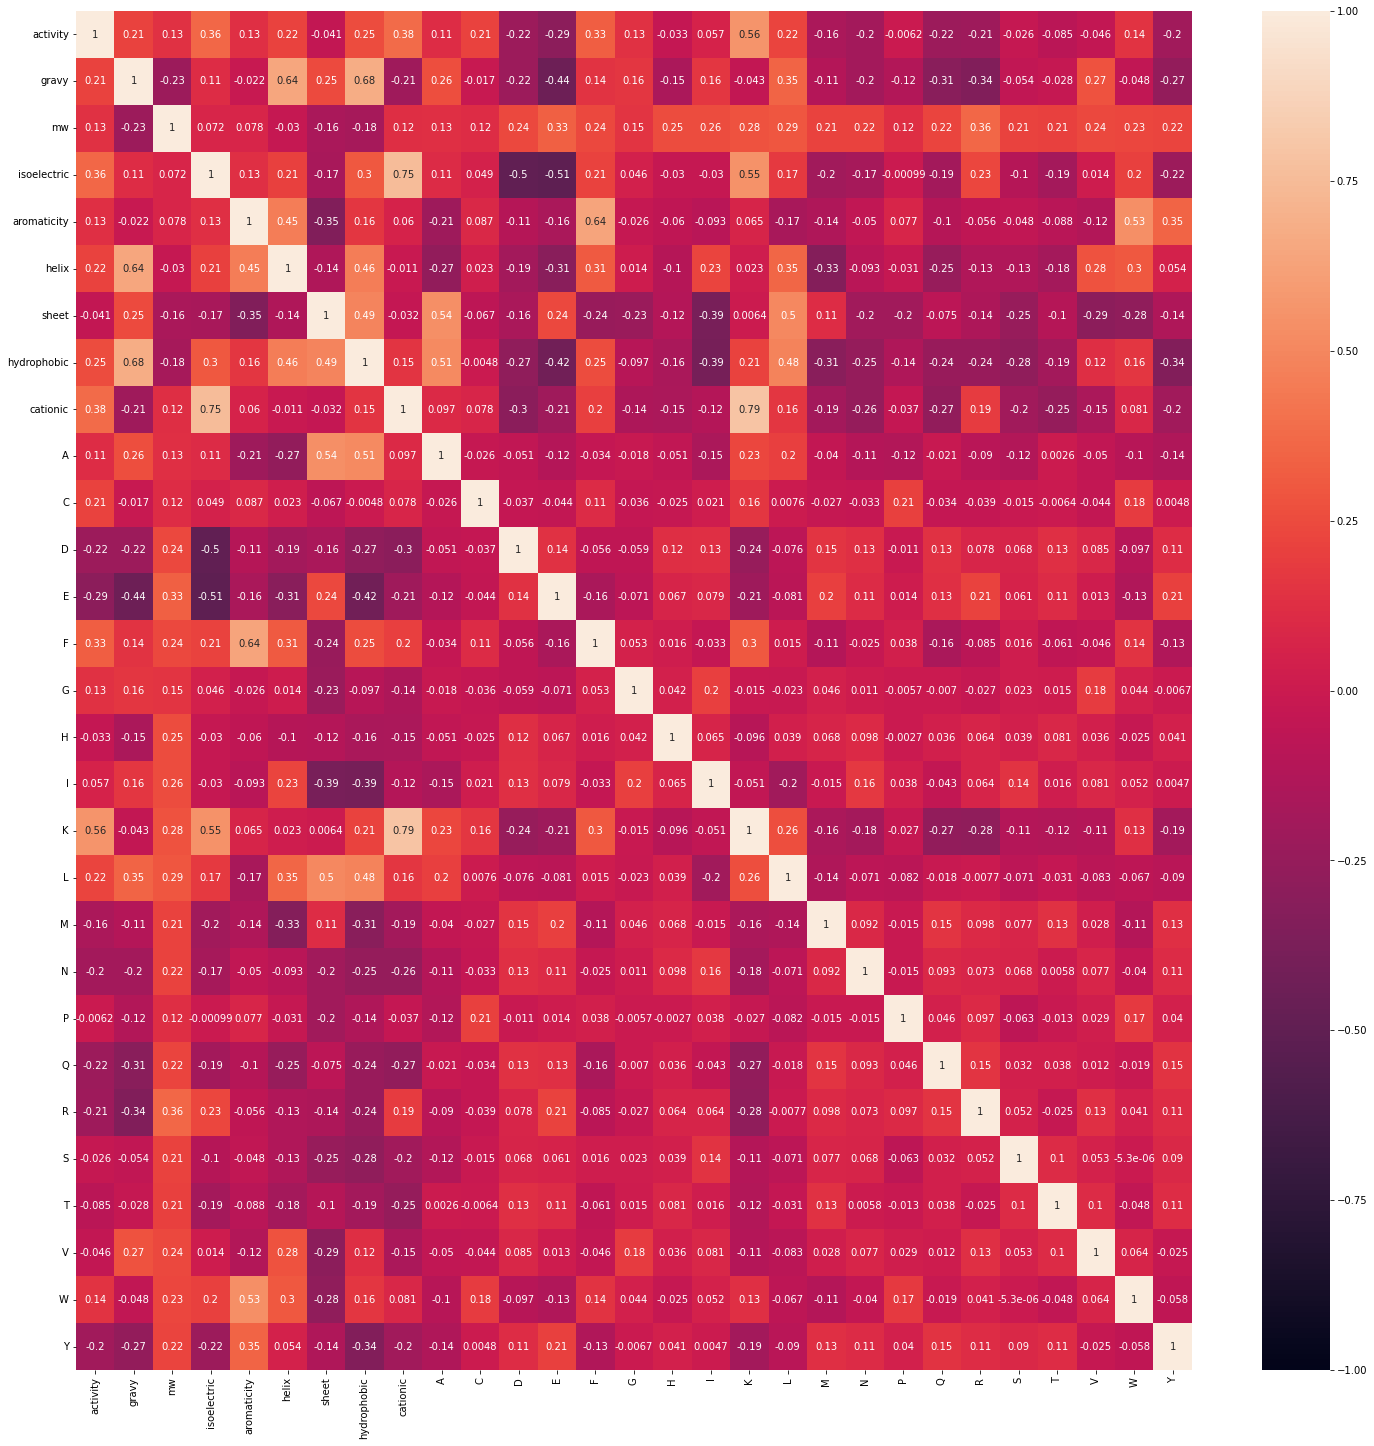

In [18]:
corr_mat2 = df2.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr_mat2, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

In [19]:
# hydrophobic, cationic, and isoelectric consistently predicts activity with correlation factors >= 0.2 in both datasets
# add feature that aggregates these continuous variables to see if we can obtain stronger predictor

df1['addfeat1'] = df1.cationic * df1.hydrophobic * df1.isoelectric**2
df2['addfeat1'] = df2.cationic * df2.hydrophobic * df2.isoelectric**2

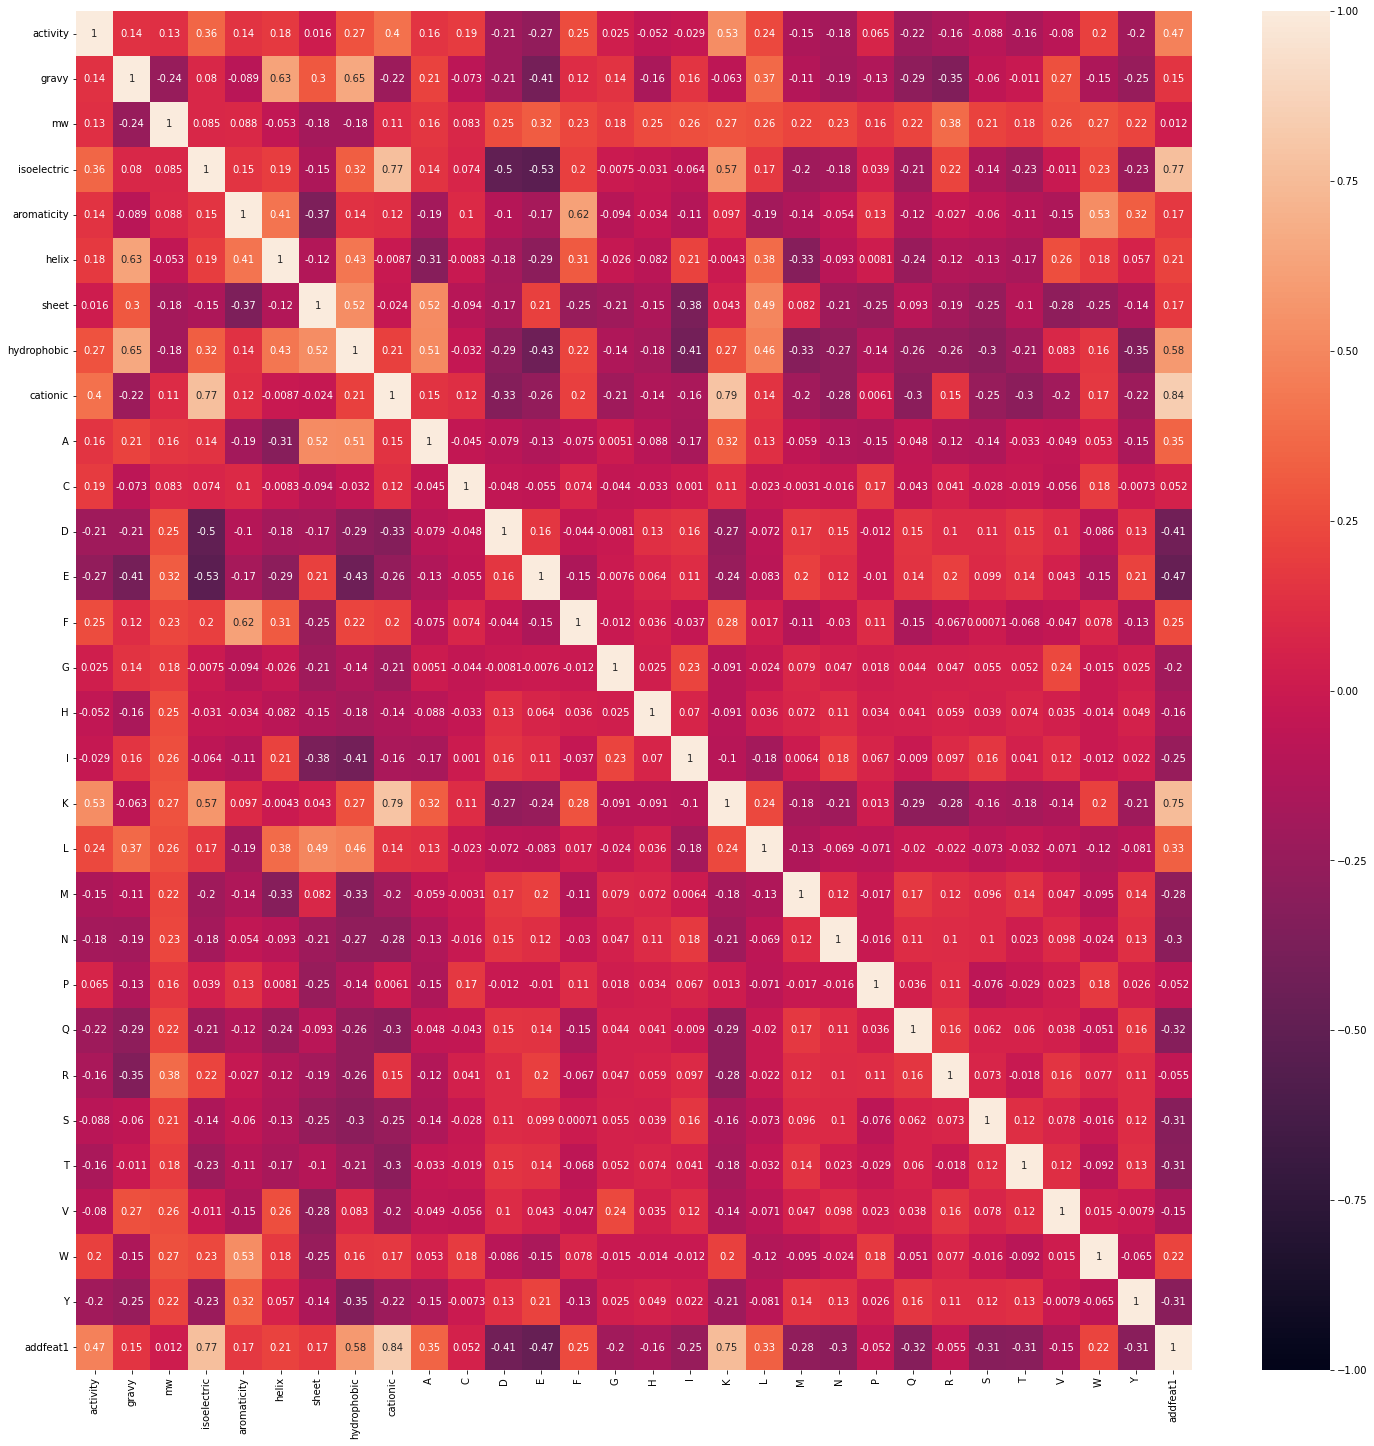

In [20]:
corr_mat1 = df1.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr_mat1, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

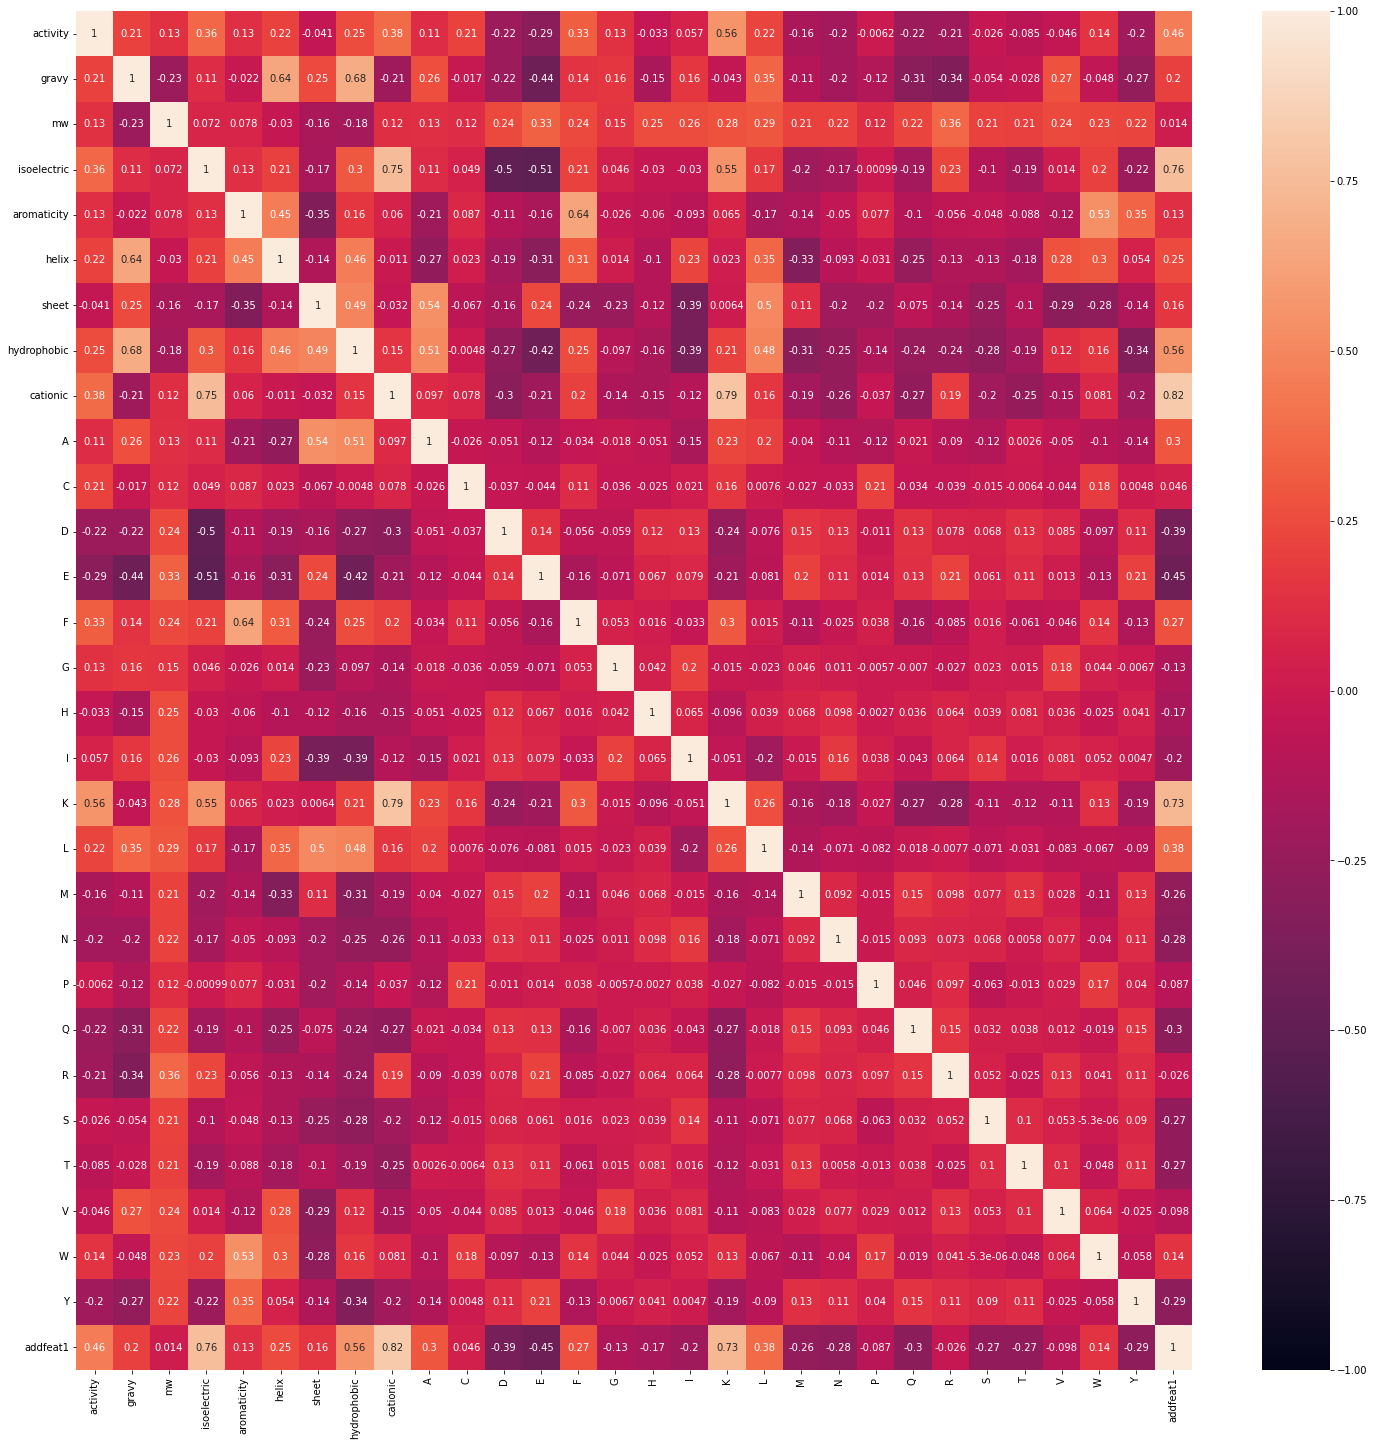

In [21]:
corr_mat2 = df2.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr_mat2, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

## Normalize and Prepare Train Test datasets

In [22]:
y1 = df1.activity
X1 = df1.drop(['sequence','prot_anal','activity'], axis=1)

In [23]:
y2 = df2.activity
X2 = df2.drop(['sequence','prot_anal','activity'], axis=1)

In [24]:
X1.head(10).T

ID,1,2,3,4,5,6,7,8,9,10
gravy,-0.742857,0.178261,-0.871429,-0.466667,-0.241667,-0.458333,0.738462,1.013333,0.738462,1.050000
mw,2485.972000,2480.923800,2601.104000,1510.644300,1508.671500,1524.670900,1414.820300,1599.055800,1524.932400,1769.307800
isoelectric,10.778485,10.001706,10.778485,4.426700,4.426700,4.426700,10.477740,10.477740,10.477740,10.602487
aromaticity,0.238095,0.130435,0.285714,0.250000,0.250000,0.250000,0.076923,0.066667,0.230769,0.062500
helix,0.238095,0.304348,0.285714,0.416667,0.416667,0.416667,0.384615,0.400000,0.461538,0.437500
sheet,0.428571,0.260870,0.380952,0.416667,0.500000,0.416667,0.615385,0.666667,0.461538,0.312500
hydrophobic,0.666667,0.347826,0.666667,0.500000,0.583333,0.500000,0.692308,0.733333,0.692308,0.375000
cationic,0.333333,0.173913,0.333333,0.083333,0.083333,0.083333,0.307692,0.266667,0.307692,0.312500
A,9.000000,3.000000,8.000000,1.000000,2.000000,1.000000,4.000000,5.000000,3.000000,4.000000
C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
def fun9(x): #, invert=False):
    """ fun1 takes an np array or pandas series variable and normalize each elements"""
    scaled = ((x-x.min())/(x.max()-x.min()))
    
    return scaled

In [26]:
X1 = fun9(X1)
X1.head(4).T

ID,1,2,3,4
gravy,0.362987,0.572332,0.333766,0.425758
mw,0.491128,0.489848,0.520315,0.243871
isoelectric,0.846353,0.748644,0.846353,0.047380
aromaticity,0.595238,0.326087,0.714286,0.625000
helix,0.255307,0.343112,0.318417,0.491968
sheet,0.535714,0.326087,0.476190,0.520833
hydrophobic,0.666667,0.347826,0.666667,0.500000
cationic,0.638889,0.333333,0.638889,0.159722
A,0.818182,0.272727,0.727273,0.090909
C,0.000000,0.000000,0.000000,0.000000


In [27]:
X2 = fun9(X2)
X2.head(4).T

ID,1,2,3,4
gravy,0.562768,0.692933,0.756801,0.692933
mw,0.542687,0.239495,0.291890,0.270810
isoelectric,0.748644,0.808523,0.808523,0.808523
aromaticity,0.239130,0.141026,0.122222,0.423077
helix,0.343112,0.449490,0.469880,0.551437
sheet,0.326087,0.769231,0.833333,0.576923
hydrophobic,0.347826,0.692308,0.733333,0.692308
cationic,0.333333,0.589744,0.511111,0.589744
A,0.300000,0.400000,0.500000,0.300000
C,0.000000,0.000000,0.000000,0.000000


In [28]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.7, random_state=4321, shuffle=True)
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)

(662, 29)
(662,)
(285, 29)
(285,)


In [29]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7, random_state=4321, shuffle=True)
print(X2_train.shape)
print(y2_train.shape)
print(X2_test.shape)
print(y2_test.shape)

(630, 29)
(630,)
(271, 29)
(271,)


## Train Random Forest Model then Evaluate prediction metrics (accuracy score & confusion matrix)

In [30]:
# instantiate RFC
em = RandomForestClassifier(n_estimators=100, random_state=4321, class_weight='balanced_subsample')  #['balanced','balanced_subsample',None] def is none

# fit training dataset for breast ca
em.fit(X1_train, y1_train)

# calc model prediction and probability that model predicts a positive label given an X in X_test
y1_predRF = em.predict(X1_test)
y1_probaRF = em.predict_proba(X1_test)

# cross validate model with test dataset
em.score(X1_test, y1_test)  # not very robust for imbalanced dataset!

0.8947368421052632

In [31]:
def plot_conf_matrix(y_true, y_pred, y_proba, labels=['Neg Category','Pos Category']):
    
    # confusion matrix calc
    cm = confusion_matrix(y_true, y_pred)

    # Plot figure and subplots
    fig = plt.figure(figsize=[12,4])

    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.35, wspace=0.05)    
    ax1 = fig.add_subplot(gs1[0, 0])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax1)#, yticklabels=labels, xticklabels=labels)
    ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels'); 
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(labels, ha='center') 
    ax1.yaxis.set_ticklabels(labels, ha='center', rotation=90, rotation_mode='anchor')

    plt.show()

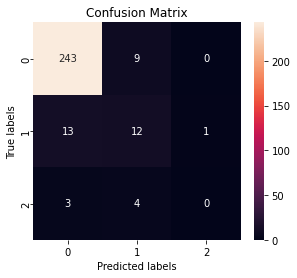

In [32]:
plot_conf_matrix(y1_test, y1_predRF, y1_probaRF, labels=['0','1','2'])

In [33]:
# instantiate RFC
em = RandomForestClassifier(n_estimators=100, random_state=4321, class_weight='balanced_subsample')  #['balanced','balanced_subsample',None] def is none

# fit training dataset for lung ca
em.fit(X2_train, y2_train)

# calc model prediction and probability that model predicts a positive label given an X in X_test
y2_predRF = em.predict(X2_test)
y2_probaRF = em.predict_proba(X2_test)

# cross validate model with test dataset
em.score(X2_test, y2_test)  # not very robust for imbalanced dataset!

0.933579335793358

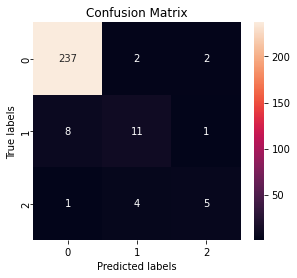

In [34]:
plot_conf_matrix(y2_test, y2_predRF, y2_probaRF, labels=['0','1','2'])

## Train KMeans model and Calculate prediction metrics

In [35]:
# instantiate initial Kmeans
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=5, random_state=4321)

# calc model prediction and probability that model predicts a certain label given an X in X_test
y1_predKM = kmeans.fit_predict(X1_test)

# cross validate model with test dataset
kmeans_score = (sum(y1_predKM==y1_test))/len(y1_predKM)  # compare predicted label and true label manually

In [36]:
print(f'Accuracy of predicted labels vs. true labels: {kmeans_score*100:.2f}% \n')
print("Kmeans' Silhouette score: ", f'{silhouette_score(X1_test,y1_predKM):.4f}')
print("Kmeans' Davies Bouldin score: ", f'{davies_bouldin_score(X1_test,y1_predKM):.4f}')
print("Kmeans' Calinski Harabasz score: ", f'{calinski_harabasz_score(X1_test,y1_predKM):.4f}')

Accuracy of predicted labels vs. true labels: 31.23% 

Kmeans' Silhouette score:  0.1747
Kmeans' Davies Bouldin score:  2.0393
Kmeans' Calinski Harabasz score:  63.6420


In [37]:
# instantiate initial Kmeans
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=5, random_state=4321)

# calc model prediction and probability that model predicts a certain label given an X in X_test
y2_predKM = kmeans.fit_predict(X2_test)

# cross validate model with test dataset
kmeans_score = (sum(y2_predKM==y2_test))/len(y2_predKM)  # compare predicted label and true label manually
                                                         # This will not be possible for unsupervised learning in general

In [38]:
print(f'Accuracy of predicted labels vs. true labels: {kmeans_score*100:.2f}% \n')
print("Kmeans' Silhouette score: ", f'{silhouette_score(X2_test,y2_predKM):.4f}')
print("Kmeans' Davies Bouldin score: ", f'{davies_bouldin_score(X2_test,y2_predKM):.4f}')
print("Kmeans' Calinski Harabasz score: ", f'{calinski_harabasz_score(X2_test,y2_predKM):.4f}')

Accuracy of predicted labels vs. true labels: 37.27% 

Kmeans' Silhouette score:  0.1333
Kmeans' Davies Bouldin score:  2.2321
Kmeans' Calinski Harabasz score:  49.9281


## Train XGBoost then Evaluate prediction metrics (accuracy score & confusion matrix)

In [39]:
# instantiate XGB model with default hyperparams
xgbm = XGBClassifier(random_state=4321)

# fit xgbm with breast ca training dataset
xgbm.fit(X1_train, y1_train)

# calc predicted val and probability of predicting certain label given an X
y1_predXGB = xgbm.predict(X1_test)
y1_probaXGB = xgbm.predict_proba(X1_test)

# crossvalidate with test ds
xgbm.score(X1_test, y1_test) 

0.8912280701754386

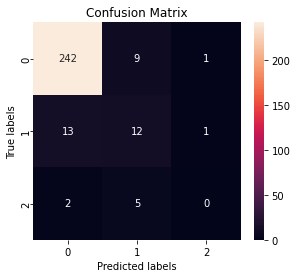

In [40]:
plot_conf_matrix(y1_test, y1_predXGB, y1_probaXGB, labels=['0','1','2'])

In [41]:
# instantiate XGB model with default hyperparams
xgbm = XGBClassifier(random_state=4321)

# fit xgbm with breast ca training dataset
xgbm.fit(X2_train, y2_train)

# calc predicted val and probability of predicting certain label given an X
y2_predXGB = xgbm.predict(X2_test)
y2_probaXGB = xgbm.predict_proba(X2_test)

# crossvalidate with test ds
xgbm.score(X2_test, y2_test) 

0.948339483394834

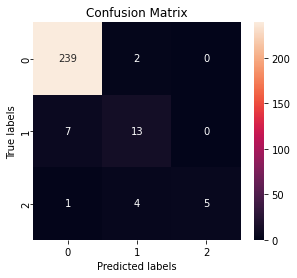

In [42]:
plot_conf_matrix(y2_test, y2_predXGB, y2_probaXGB, labels=['0','1','2'])

### __Conclusions:__

1. XGBoost algorithm performed the best (94% classification accuracy) among the employed predictive models. Nonetheless, confusion matrix profile suggests that there are still some rooms for improvement for all the tested models, probably due to imbalanced ACP molecule datasets. 
2. Unsupervised KMeans clustering algorithm didn't seem fitting for this purpose. 
3. In real scenario, model can be applied as computational guide (using available historical data, ideally obtained from same experimental protocols/conditions) for designing novel APC candidate molecules to be tested/validated in the lab as part of the itterative cycle [3].

### __References:__
1. https://archive.ics.uci.edu/ml/datasets/Anticancer+peptides#. 
2. https://biopython.org/docs/latest/api/Bio.SeqUtils.ProtParam.html
3. https://link.springer.com/article/10.1007/s00894-019-4007-6